In [6]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # "0, 1" for multiple
# http://forums.fast.ai/t/tip-limiting-tensorflow-to-one-gpu/1995

In [7]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import scipy
import skimage.transform

import keras

from keras import backend as K  # set the data format as 'channels_first'

from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical

from keras import applications  # VGG model

from keras.models import Sequential, Model
from keras.layers import Input, Embedding, Reshape, merge, LSTM, Bidirectional, concatenate
from keras.layers import TimeDistributed, Activation, SimpleRNN, GRU, GlobalAveragePooling2D
from keras.layers.core import Flatten, Dense, Dropout, Lambda
#from keras.regularizers import l2, activity_l2, l1, activity_l1

from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
#from keras.utils.layer_utils import layer_from_config
from keras.metrics import categorical_crossentropy, categorical_accuracy

from keras.layers.convolutional import *
from keras.preprocessing import image, sequence
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.text import Tokenizer

from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard  # callbacks

from glob import glob
import os
import bcolz
import ujson as json
import PIL

from scipy import ndimage
from collections import defaultdict

# import h5py

In [15]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [8]:
PATH_IMAGES = "/home/julien/tractable_images/"

## Create datasets (run only once)

In [179]:
df = pd.read_csv('./flwing_part-big_split.csv')
# There are a lot of duplicates (by image_id), we need to remove them.
df = df.drop_duplicates("image_id")

In [180]:
# We also remove all of the images which are in the csv file,
# but not in the directory.
all_images = os.listdir(PATH_IMAGES)
s = set(list(df["image_id"])) - set([x[:-4] for x in all_images])
df = df[~df["image_id"].isin(s)]

In [181]:
# Check that the csv contains the same number of images
# as the directory: 486713.
df.shape

(486713, 5)

In [182]:
df = df.drop(["b'imbag_id'", "set:"], axis=1)

In [183]:
df_flwing = df[df['flwing']==1]
df_not_flwing = df[df['flwing']==0]

In [184]:
val1 = df_flwing.sample(5000)
val2 = df_not_flwing.sample(5000)
val = pd.concat([val1, val2])
#del val1; del val2

df_flwing = df_flwing.drop(val1.index)
df_not_flwing = df_not_flwing.drop(val2.index)

In [185]:
test1 = df_flwing.sample(5000)
test2 = df_not_flwing.sample(5000)
test = pd.concat([test1, test2])
#del val1; del val2

df_flwing = df_flwing.drop(test1.index)
df_not_flwing = df_not_flwing.drop(test2.index)

In [213]:
for image in list(val1["image_id"]):
    os.rename(PATH_IMAGES+"{}.jpg".format(image),
             PATH_IMAGES+"val/flwing/{}.jpg".format(image))

for image in list(val2["image_id"]):
    os.rename(PATH_IMAGES+"{}.jpg".format(image),
             PATH_IMAGES+"val/not_flwing/{}.jpg".format(image))

In [212]:
for image in list(test1["image_id"]):
    os.rename(PATH_IMAGES+"{}.jpg".format(image),
             PATH_IMAGES+"test/flwing/{}.jpg".format(image))

for image in list(test2["image_id"]):
    os.rename(PATH_IMAGES+"{}.jpg".format(image),
             PATH_IMAGES+"test/not_flwing/{}.jpg".format(image))

In [206]:
for image in list(df_flwing["image_id"]):
    os.rename(PATH_IMAGES+"{}.jpg".format(image),
             PATH_IMAGES+"train/flwing/{}.jpg".format(image))

for image in list(df_not_flwing["image_id"]):
    os.rename(PATH_IMAGES+"{}.jpg".format(image),
             PATH_IMAGES+"train/not_flwing/{}.jpg".format(image))

### Visualization (useful cells, keep them for later)

In [7]:
# dossier avec les images.
# ./tractable_images

In [84]:
import matplotlib.pyplot as plt

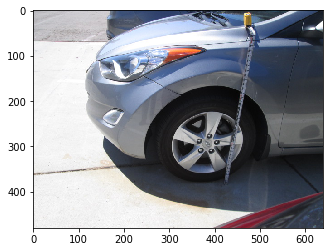

In [85]:
index = 25
image = plt.imread('./tractable_images/{}.jpg'.format(df.iloc[index]['image_id']))
plt.imshow(image)

## Classifier (resize)

In [9]:
batch_size = 64
target_size = (224,224)

In [359]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        #featurewise_center=True,
        #featurewise_std_normalization=True,
        width_shift_range=0.125,
        height_shift_range=0.125,
        fill_mode='constant', cval=0.,
        shear_range=0.2,
        zoom_range=(0.7, 1.2),
        rotation_range=25
)

train_generator = train_datagen.flow_from_directory(
    directory=PATH_IMAGES+"train/",
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

Found 466713 images belonging to 2 classes.


In [360]:
valid_datagen = ImageDataGenerator(
        rescale=1./255,
        #featurewise_center=True,
        #featurewise_std_normalization=True,
        width_shift_range=0.125,
        height_shift_range=0.125,
        fill_mode='constant', cval=0.,
        shear_range=0.2,
        zoom_range=(0.7, 1.2),
        rotation_range=25
)

valid_generator = valid_datagen.flow_from_directory(
    directory=PATH_IMAGES+"val/",
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

Found 10000 images belonging to 2 classes.


In [372]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    directory=PATH_IMAGES+"test/",
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 10000 images belonging to 2 classes.


In [219]:
train_generator.n

466713

In [259]:
base_model = applications.VGG16(include_top=False, weights='imagenet')#, input_shape=(3,)+target_size)

i=0
for layer in base_model.layers:
    layer.trainable = False
    i = i+1
    print(i,layer.name)

1 input_3
2 block1_conv1
3 block1_conv2
4 block1_pool
5 block2_conv1
6 block2_conv2
7 block2_pool
8 block3_conv1
9 block3_conv2
10 block3_conv3
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_pool
16 block5_conv1
17 block5_conv2
18 block5_conv3
19 block5_pool


In [361]:
x = base_model.output
#x = Dense(128, activation='relu')(x)
x = GlobalAveragePooling2D()(x)
#x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(2, activation='sigmoid')(x)

In [313]:
# nf=128; p=0.5
# x = base_model.output
# #print(x.shape[1:])
# #x = BatchNormalization(axis=1, input_shape=x.shape[1:])(x)
# x = Convolution2D(nf,(3,3), activation='relu', padding='same')(x)
# x = Dropout(p)(x)
# #x = BatchNormalization(axis=1, input_shape=x.shape)(x)
# x = Convolution2D(nf,(3,3), activation='relu', padding='same')(x)
# x = Dropout(p)(x)
# #x = BatchNormalization(axis=1)(x)
# x = Convolution2D(nf,(3,3), activation='relu', padding='same')(x)
# x = Dropout(p)(x)
# #x = BatchNormalization(axis=1)(x)
# x = Convolution2D(2,(3,3), padding='same')(x)
# x = Dropout(p)(x)
# predictions = GlobalAveragePooling2D()(x)
# #x = GlobalAveragePooling2D()(x)
# #predictions = Activation('sigmoid')(x)

In [362]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [363]:
class_weight = {0: 5., 1: 1.}

In [364]:
#checkpointer = ModelCheckpoint(filepath=path+'results/models/top_model_high_res_640.hdf5',
#                               verbose=1, save_best_only=True)
checkpointer = ModelCheckpoint(filepath="classifier_2.hdf5",
                               verbose=1, save_best_only=True)    
earlystop = EarlyStopping(monitor="val_loss", patience=20)
tensorboard = TensorBoard(log_dir="c2_logs")
callbacks_list = [checkpointer, earlystop, tensorboard]

In [365]:
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.001), metrics=["accuracy"])


STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size  # 7292
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size  # 156
model.fit_generator(
        train_generator,
        steps_per_epoch=1823,
        epochs=100,
        #callbacks = callbacks_list,
        validation_data = valid_generator,
        validation_steps=52,
        class_weight=class_weight,
        callbacks=callbacks_list
        )

Epoch 1/100
  69/1823 [>.............................] - ETA: 31:46 - loss: 0.9202 - acc: 0.8308

/home/julien/miniconda3/envs/project/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:790: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn("Image appears to be a malformed MPO file, it will be "


 189/1823 [==>...........................] - ETA: 29:02 - loss: 0.8430 - acc: 0.7878

/home/julien/miniconda3/envs/project/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 16843011 bytes but only got 0. Skipping tag 64249
  " Skipping tag %s" % (size, len(data), tag))
/home/julien/miniconda3/envs/project/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))


 616/1823 [=========>....................] - ETA: 21:32 - loss: 0.7236 - acc: 0.8064

/home/julien/miniconda3/envs/project/lib/python3.6/site-packages/PIL/Image.py:2514: DecompressionBombWarning: Image size (139201551 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


1823/1823 [==============================] - 2013s 1s/step - loss: 0.6402 - acc: 0.8322 - val_loss: 0.4167 - val_acc: 0.8083

Epoch 00001: val_loss improved from inf to 0.41668, saving model to classifier_2.hdf5
Epoch 2/100
 138/1823 [=>............................] - ETA: 27:51 - loss: 0.5585 - acc: 0.8621

/home/julien/miniconda3/envs/project/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8589934590 bytes but only got 29023. Skipping tag 34855
  " Skipping tag %s" % (size, len(data), tag))


1266/1823 [===================>..........] - ETA: 9:53 - loss: 0.5507 - acc: 0.8639

/home/julien/miniconda3/envs/project/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 1. 
  warnings.warn(str(msg))


1823/1823 [==============================] - 1999s 1s/step - loss: 0.5474 - acc: 0.8649 - val_loss: 0.4192 - val_acc: 0.8011

Epoch 00002: val_loss did not improve from 0.41668
Epoch 3/100
 112/1823 [>.............................] - ETA: 27:41 - loss: 0.5406 - acc: 0.8729

/home/julien/miniconda3/envs/project/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1769472 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


1623/1823 [=========================>....] - ETA: 3:33 - loss: 0.5272 - acc: 0.8725

/home/julien/miniconda3/envs/project/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 9. 
  warnings.warn(str(msg))


1823/1823 [==============================] - 2000s 1s/step - loss: 0.5252 - acc: 0.8728 - val_loss: 0.3350 - val_acc: 0.8483

Epoch 00003: val_loss improved from 0.41668 to 0.33495, saving model to classifier_2.hdf5
Epoch 4/100
1823/1823 [==============================] - 1990s 1s/step - loss: 0.5084 - acc: 0.8793 - val_loss: 0.3264 - val_acc: 0.8558

Epoch 00004: val_loss improved from 0.33495 to 0.32643, saving model to classifier_2.hdf5
Epoch 5/100
1823/1823 [==============================] - 2008s 1s/step - loss: 0.4895 - acc: 0.8807 - val_loss: 0.3142 - val_acc: 0.8591

Epoch 00005: val_loss improved from 0.32643 to 0.31422, saving model to classifier_2.hdf5
Epoch 6/100
1823/1823 [==============================] - 1996s 1s/step - loss: 0.4864 - acc: 0.8843 - val_loss: 0.3102 - val_acc: 0.8603

Epoch 00006: val_loss improved from 0.31422 to 0.31025, saving model to classifier_2.hdf5
Epoch 7/100
1823/1823 [==============================] - 1995s 1s/step - loss: 0.4777 - acc: 0.8873 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1823/1823 [==============================] - 1993s 1s/step - loss: 0.4556 - acc: 0.8942 - val_loss: 0.2960 - val_acc: 0.8684

Epoch 00010: val_loss improved from 0.31025 to 0.29600, saving model to classifier_2.hdf5
Epoch 11/100
1823/1823 [==============================] - 1999s 1s/step - loss: 0.4558 - acc: 0.8916 - val_loss: 0.2899 - val_acc: 0.8750

Epoch 00011: val_loss improved from 0.29600 to 0.28994, saving model to classifier_2.hdf5
Epoch 12/100
1823/1823 [==============================] - 1998s 1s/step - loss: 0.4423 - acc: 0.8961 - val_loss: 0.3003 - val_acc: 0.8651

Epoch 00012: val_loss did not improve from 0.28994
Epoch 13/100
1823/1823 [==============================] - 2006s 1s/step - loss: 0.4430 - acc: 0.8964 - val_loss: 0.2770 - val_acc: 0.8792

Epoch 00013: val_loss improved from 0.28994 to 0.27700, saving model to classifier_2.hdf5
Epoch 14/100
1721/1823 [===========================>..] - ETA: 1:48 - loss: 0.4428 - acc: 0.8971

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1823/1823 [==============================] - 2010s 1s/step - loss: 0.4234 - acc: 0.8997 - val_loss: 0.2817 - val_acc: 0.8723

Epoch 00017: val_loss did not improve from 0.27171
Epoch 18/100
1823/1823 [==============================] - 1999s 1s/step - loss: 0.4341 - acc: 0.8990 - val_loss: 0.2888 - val_acc: 0.8744

Epoch 00018: val_loss did not improve from 0.27171
Epoch 19/100
 426/1823 [======>.......................] - ETA: 24:23 - loss: 0.4247 - acc: 0.9015

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1823/1823 [==============================] - 2009s 1s/step - loss: 0.4264 - acc: 0.9011 - val_loss: 0.2624 - val_acc: 0.8903

Epoch 00021: val_loss improved from 0.26975 to 0.26235, saving model to classifier_2.hdf5
Epoch 22/100
1823/1823 [==============================] - 1997s 1s/step - loss: 0.4122 - acc: 0.9026 - val_loss: 0.2944 - val_acc: 0.8681

Epoch 00022: val_loss did not improve from 0.26235
Epoch 23/100
1025/1823 [===============>..............] - ETA: 14:08 - loss: 0.4111 - acc: 0.9044

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1823/1823 [==============================] - 1997s 1s/step - loss: 0.4225 - acc: 0.9025 - val_loss: 0.2933 - val_acc: 0.8642

Epoch 00024: val_loss did not improve from 0.26235
Epoch 25/100
1586/1823 [=========================>....] - ETA: 4:13 - loss: 0.4128 - acc: 0.9023

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1823/1823 [==============================] - 2001s 1s/step - loss: 0.4097 - acc: 0.9045 - val_loss: 0.2635 - val_acc: 0.8930

Epoch 00028: val_loss did not improve from 0.26028
Epoch 29/100
1823/1823 [==============================] - 2012s 1s/step - loss: 0.4101 - acc: 0.9052 - val_loss: 0.2524 - val_acc: 0.8969

Epoch 00029: val_loss improved from 0.26028 to 0.25240, saving model to classifier_2.hdf5
Epoch 30/100
 160/1823 [=>............................] - ETA: 27:55 - loss: 0.4043 - acc: 0.9047

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1823/1823 [==============================] - 2003s 1s/step - loss: 0.3996 - acc: 0.9083 - val_loss: 0.2650 - val_acc: 0.8885

Epoch 00032: val_loss did not improve from 0.25240
Epoch 33/100
1823/1823 [==============================] - 2009s 1s/step - loss: 0.4067 - acc: 0.9061 - val_loss: 0.2645 - val_acc: 0.8888

Epoch 00033: val_loss did not improve from 0.25240
Epoch 34/100
 327/1823 [====>.........................] - ETA: 25:49 - loss: 0.3931 - acc: 0.9083

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1823/1823 [==============================] - 2001s 1s/step - loss: 0.4061 - acc: 0.9084 - val_loss: 0.2710 - val_acc: 0.8834

Epoch 00036: val_loss did not improve from 0.25240
Epoch 37/100
1823/1823 [==============================] - 2005s 1s/step - loss: 0.4002 - acc: 0.9088 - val_loss: 0.2700 - val_acc: 0.8912

Epoch 00037: val_loss did not improve from 0.25240
Epoch 38/100
 733/1823 [===========>..................] - ETA: 19:11 - loss: 0.3900 - acc: 0.9087

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1823/1823 [==============================] - 2005s 1s/step - loss: 0.3975 - acc: 0.9094 - val_loss: 0.2636 - val_acc: 0.8903

Epoch 00041: val_loss did not improve from 0.25240
Epoch 42/100
1386/1823 [=====================>........] - ETA: 7:44 - loss: 0.3947 - acc: 0.9106

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1823/1823 [==============================] - 1994s 1s/step - loss: 0.3938 - acc: 0.9103 - val_loss: 0.2706 - val_acc: 0.8816

Epoch 00044: val_loss did not improve from 0.25240
Epoch 45/100
1823/1823 [==============================] - 2003s 1s/step - loss: 0.3908 - acc: 0.9095 - val_loss: 0.2604 - val_acc: 0.8906

Epoch 00045: val_loss did not improve from 0.25240
Epoch 46/100
1823/1823 [==============================] - 1995s 1s/step - loss: 0.3882 - acc: 0.9125 - val_loss: 0.2565 - val_acc: 0.8894

Epoch 00046: val_loss did not improve from 0.25240
Epoch 47/100
1823/1823 [==============================] - 1996s 1s/step - loss: 0.3914 - acc: 0.9100 - val_loss: 0.2729 - val_acc: 0.8861

Epoch 00047: val_loss did not improve from 0.25240
Epoch 48/100
1823/1823 [==============================] - 2000s 1s/step - loss: 0.3926 - acc: 0.9088 - val_loss: 0.2439 - val_acc: 0.8966

Epoch 00048: val_loss improved from 0.25240 to 0.24389, saving model to classifier_2.hdf5
Epoch 49/100
1823/1823 [

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1823/1823 [==============================] - 2000s 1s/step - loss: 0.3821 - acc: 0.9135 - val_loss: 0.2534 - val_acc: 0.8942

Epoch 00066: val_loss did not improve from 0.24389
Epoch 67/100
1823/1823 [==============================] - 1991s 1s/step - loss: 0.3753 - acc: 0.9135 - val_loss: 0.2512 - val_acc: 0.8915

Epoch 00067: val_loss did not improve from 0.24389
Epoch 68/100
 254/1823 [===>..........................] - ETA: 26:47 - loss: 0.3793 - acc: 0.9150

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1823/1823 [==============================] - 1996s 1s/step - loss: 0.3854 - acc: 0.9145 - val_loss: 0.2408 - val_acc: 0.8969

Epoch 00070: val_loss improved from 0.24389 to 0.24084, saving model to classifier_2.hdf5
Epoch 71/100
1823/1823 [==============================] - 2002s 1s/step - loss: 0.3806 - acc: 0.9145 - val_loss: 0.2551 - val_acc: 0.8906

Epoch 00071: val_loss did not improve from 0.24084
Epoch 72/100
 904/1823 [=============>................] - ETA: 16:13 - loss: 0.3840 - acc: 0.9105

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1823/1823 [==============================] - 1999s 1s/step - loss: 0.3791 - acc: 0.9148 - val_loss: 0.2443 - val_acc: 0.8975

Epoch 00075: val_loss did not improve from 0.24084
Epoch 76/100
1321/1823 [====================>.........] - ETA: 8:53 - loss: 0.3737 - acc: 0.9181

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1823/1823 [==============================] - 1987s 1s/step - loss: 0.3742 - acc: 0.9169 - val_loss: 0.2704 - val_acc: 0.8828

Epoch 00079: val_loss did not improve from 0.24084
Epoch 80/100
1823/1823 [==============================] - 1994s 1s/step - loss: 0.3788 - acc: 0.9167 - val_loss: 0.2417 - val_acc: 0.9029

Epoch 00080: val_loss did not improve from 0.24084
Epoch 81/100
 222/1823 [==>...........................] - ETA: 27:17 - loss: 0.3691 - acc: 0.9163

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1823/1823 [==============================] - 1985s 1s/step - loss: 0.3814 - acc: 0.9158 - val_loss: 0.2464 - val_acc: 0.8987

Epoch 00083: val_loss did not improve from 0.24084
Epoch 84/100
1823/1823 [==============================] - 1986s 1s/step - loss: 0.3679 - acc: 0.9172 - val_loss: 0.2610 - val_acc: 0.8924

Epoch 00084: val_loss did not improve from 0.24084
Epoch 85/100
 588/1823 [========>.....................] - ETA: 21:36 - loss: 0.3676 - acc: 0.9184

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1823/1823 [==============================] - 1996s 1s/step - loss: 0.3746 - acc: 0.9168 - val_loss: 0.2614 - val_acc: 0.8885

Epoch 00088: val_loss did not improve from 0.24084
Epoch 89/100
1270/1823 [===================>..........] - ETA: 9:47 - loss: 0.3709 - acc: 0.9165

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [382]:
STEP_SIZE_TRAIN, STEP_SIZE_VALID

(7292, 156)

In [367]:
import pickle
with open('./trainHistoryDict_2.p', 'wb') as file_pi:
    pickle.dump(model.history.history, file_pi)

# model.save("./classifier_1.h5")

In [ ]:
# from keras.models import load_model

In [2]:
import pickle
with open('./trainHistoryDict_2.p', 'rb') as file_pi:
    history = pickle.load(file_pi)

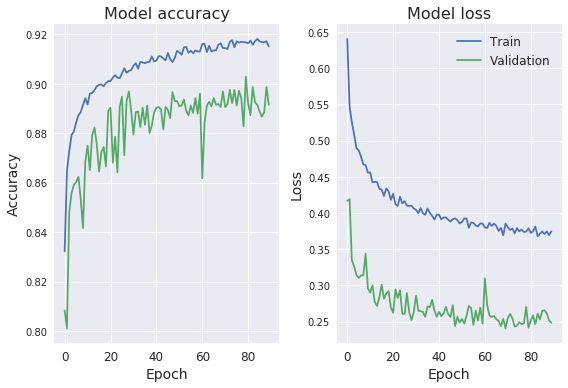

In [6]:
plt.style.use('seaborn')
# summarize history for accuracy
plt.subplot(1, 2, 1)
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('Model accuracy', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
#plt.legend(['Train', 'Validation'], loc='upper left', fontsize=12)
plt.xticks(fontsize=12)
#plt.show()
# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss', fontsize=16)
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=12)
plt.xticks(fontsize=12)
plt.tight_layout()
plt.savefig("./visualizations/classifier_resize_training.png", dpi=200)#bbox_inches="tight", dpi=200)

In [373]:
## previous model, classifier_1
# model.evaluate_generator(
#         test_generator,
#         steps=52
# )

[0.2833129328030806, 0.8762019230769231]

In [12]:
from keras.models import load_model
model2 = load_model("classifier_2.hdf5")

In [381]:
model2.evaluate_generator(
        test_generator,
        steps=52
)

[0.2225601478264882, 0.9014423076923077]

In [383]:
model2.evaluate_generator(
        test_generator,
        steps=156
)

/home/julien/miniconda3/envs/project/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:790: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn("Image appears to be a malformed MPO file, it will be "


[0.207972423101847, 0.9150641025641025]

In [386]:
test_datagen_heatmaps = ImageDataGenerator(rescale=1./255)

test_generator_heatmaps = test_datagen_heatmaps.flow_from_directory(
    directory="/home/julien/crops_heatmaps/",
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 10000 images belonging to 2 classes.


In [387]:
model2.evaluate_generator(
        test_generator_heatmaps,
        steps=156
)

[0.5007954465273099, 0.7830528846153846]

In [7]:
test_datagen_heatmaps_100 = ImageDataGenerator(rescale=1./255)

test_generator_heatmaps_100 = test_datagen_heatmaps_100.flow_from_directory(
    directory="/home/julien/crops_heatmaps_2/",
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 10000 images belonging to 2 classes.


In [8]:
model2.evaluate_generator(
        test_generator_heatmaps_100,
        steps=156
)

[0.26818434067834646, 0.8832131410256411]

In [9]:
test_datagen_heatmaps_50 = ImageDataGenerator(rescale=1./255)

test_generator_heatmaps_50 = test_datagen_heatmaps_50.flow_from_directory(
    directory="/home/julien/crops_heatmaps_3/",
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 10000 images belonging to 2 classes.


In [10]:
model2.evaluate_generator(
        test_generator_heatmaps_50,
        steps=156
)

[0.20768131086459526, 0.9144631410256411]

In [16]:
test_datagen_frcnn = ImageDataGenerator(rescale=1./255)

test_generator_frcnn = test_datagen_frcnn.flow_from_directory(
    directory="/home/julien/crops_frcnn/",
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 10000 images belonging to 2 classes.


In [17]:
model2.evaluate_generator(
    test_generator_frcnn,
    steps=156,
)

[0.422854070766614, 0.8238181089743589]